# Input

Time series $Z$ mixed with noise
$$Y = Z + E,$$
where $E$ is a whitenoise
$$
cov(E_i, E_j) =
\begin{cases}
\sigma_e^2,& i = j \\
0,&          i \neq j
\end{cases} 
$$

$Z$ depends on $X_i, i = 1..6$ time series.

# Task
- Find and remove anomalies in $Y$
- Create regression model $\mu$: $Z = \mu\left( X \right)$
- Find prediction for three more values of $Z$ by
  - extrapolation of $Z$
  - model $\mu\left( X \right)$ and prediction of $X$
- Estimate prediction errors
- Choose the best prediction

# Tools
- [Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)
- [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (!code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Toggle</a> the raw code.''')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [3]:
from matplotlib import rc
rc('font', size=18)

In [4]:
from numpy import loadtxt, arange, log, delete, array, ones, concatenate
from numpy.linalg import lstsq
from scipy.stats import f
from scipy.stats.mstats import normaltest
from pandas.stats.moments import ewma
from pandas import Series

In [5]:
from common import *

In [6]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()

In [7]:
F_TAIL_CRITICAL = 0.1

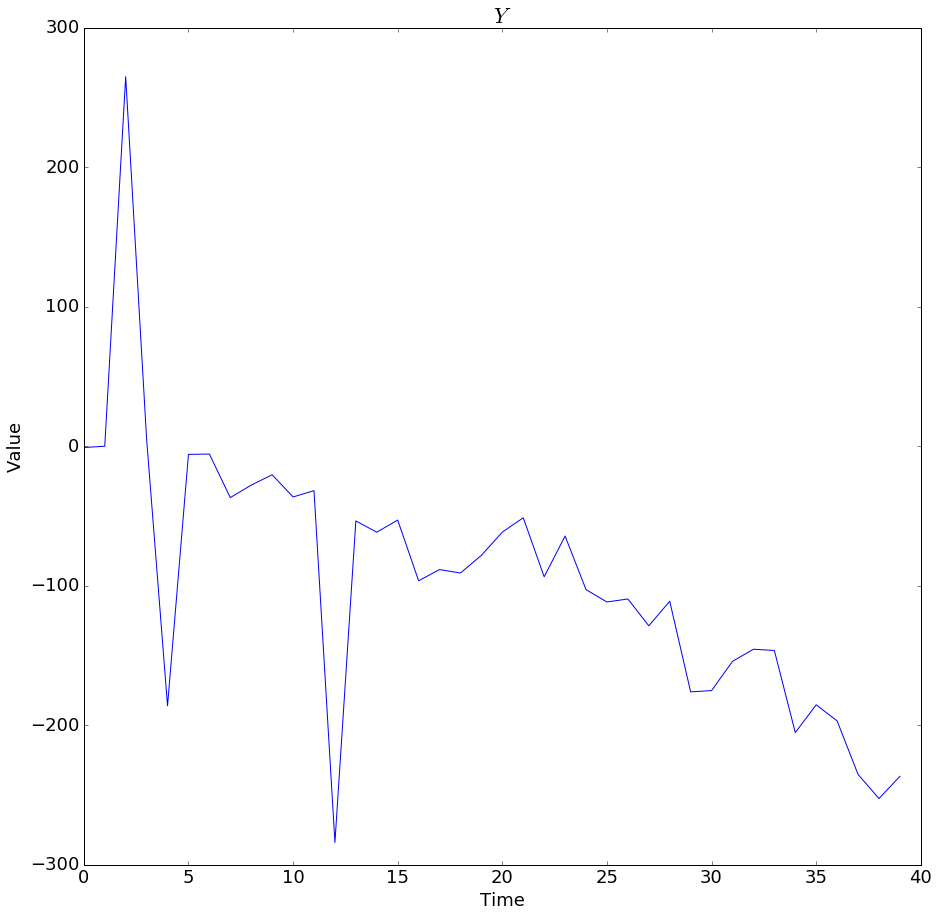

In [8]:
plt.plot(t, y)
plt.title('$Y$')
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

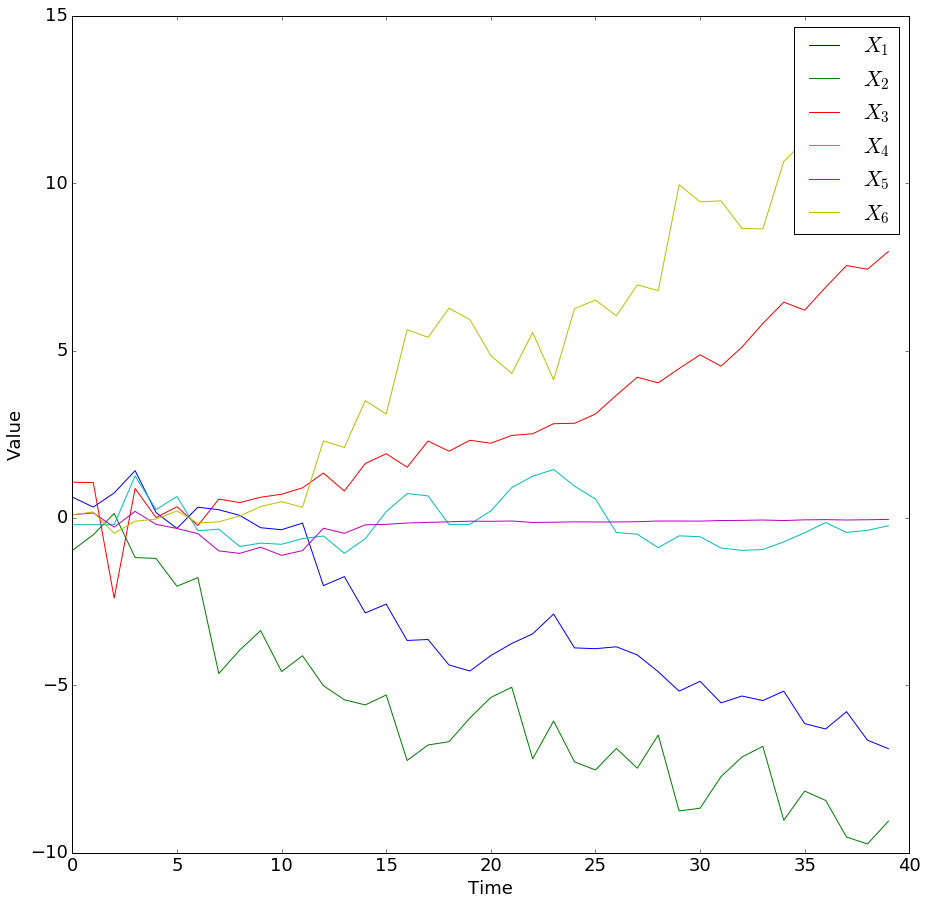

In [9]:
for i, x in enumerate(xs):
    plt.plot(t, x, label='$X_%d$'%(i+1))

plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

# Smoothing

## Initial smoothing

Exponential moving average with window size $6$ will be used

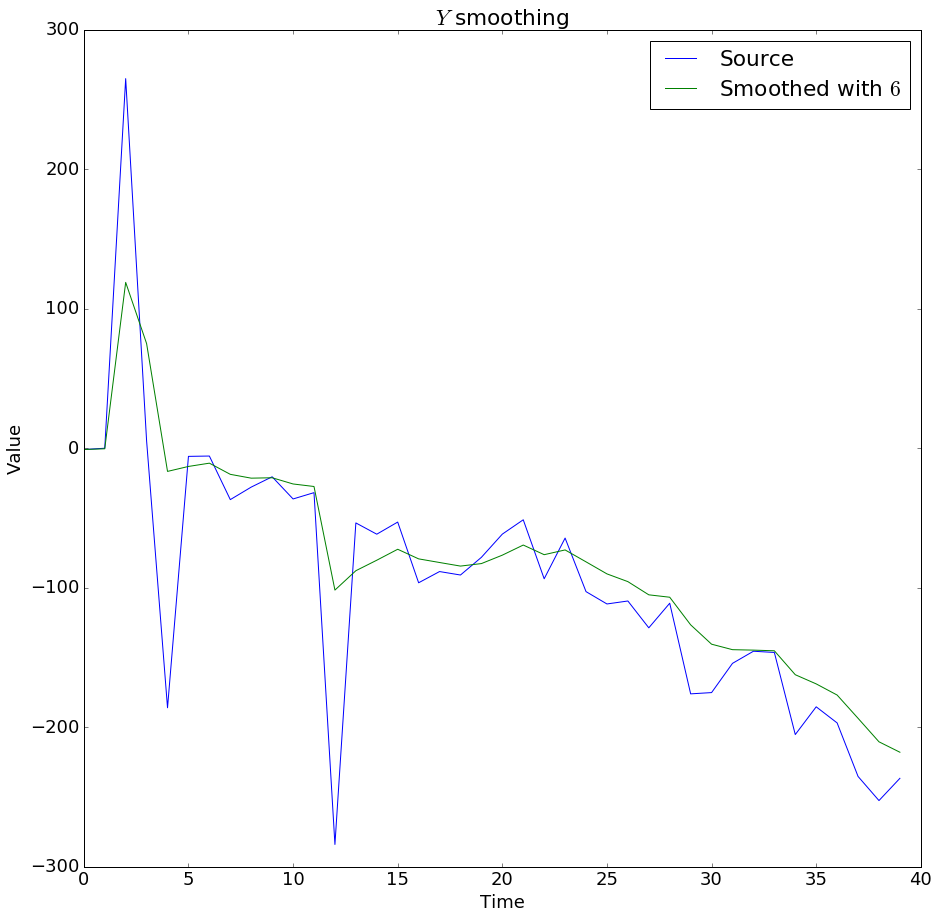

In [10]:
span = 6
smoothed_y = data_smoother(y, span=span)

plt.plot(t, y, label='Source')
plt.plot(t, smoothed_y, label='Smoothed with $%d$'%span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Find anomalies

Anomaly points are the ones which affect smoothing.

We can find them as points which increase standard deviation of smoothing errors a lot.

Given an anomaly point $t$ we can build new time series $Y_{fixed}\left( t \right)$ without this point
and check whether this point is really anomaly
$$
V\left( t \right)
= \frac{Var\left( Y - Y^{smoothed} \right)}
       {Var\left( Y_{fixed}\left(t\right) - Y_{fixed}^{smoothed}\left(t\right) \right)}
> V_{critical}
$$

It's an [F-test](https://en.wikipedia.org/wiki/F-test) and we can do it in following way
$$
\max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)} > F_{F, T, T-1}^{critical}
\Longrightarrow
t_{anomaly} = \max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)}.
$$
because errors have normal distribution by initial conditions.

Let's take a look on variances of fixed time series, which don't contain specific points

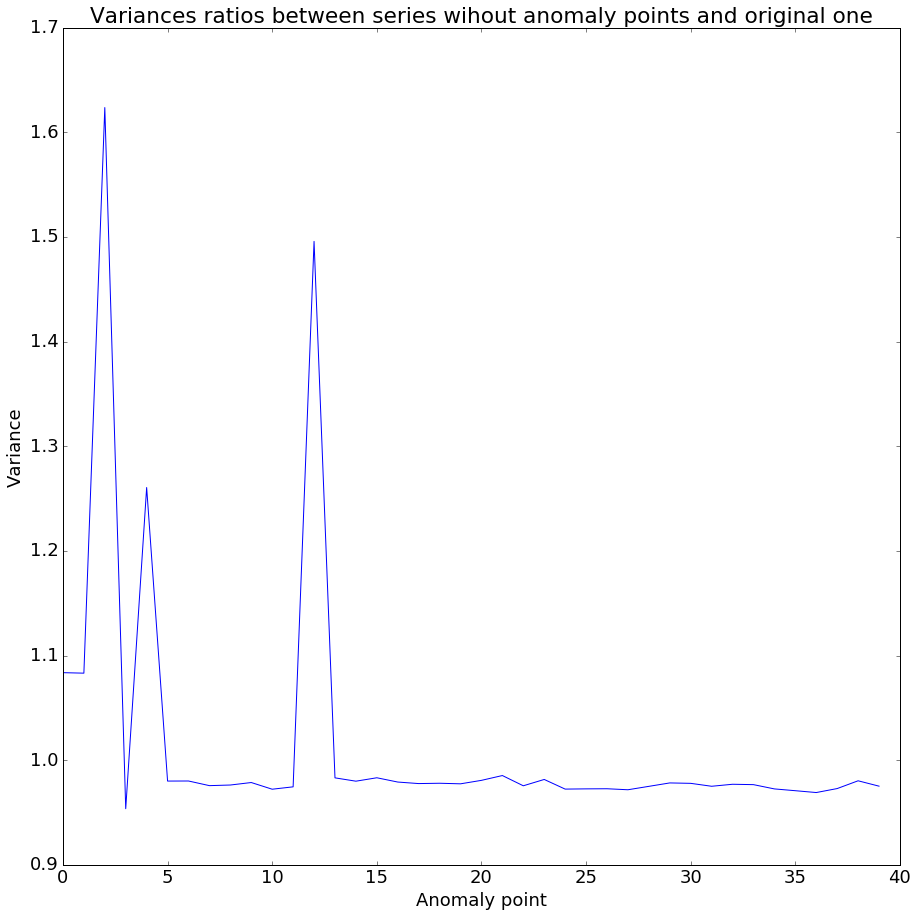

In [11]:
anomalies = get_f_test_values(y, span)
f_test = get_f_weights(anomalies)

plt.plot(t, anomalies)
plt.title('Variances ratios between series wihout anomaly points and original one')
plt.xlabel('Anomaly point')
plt.ylabel('Variance')
plt.show()

Plot which contains weight of Fisher distribution tails for each fixed time series

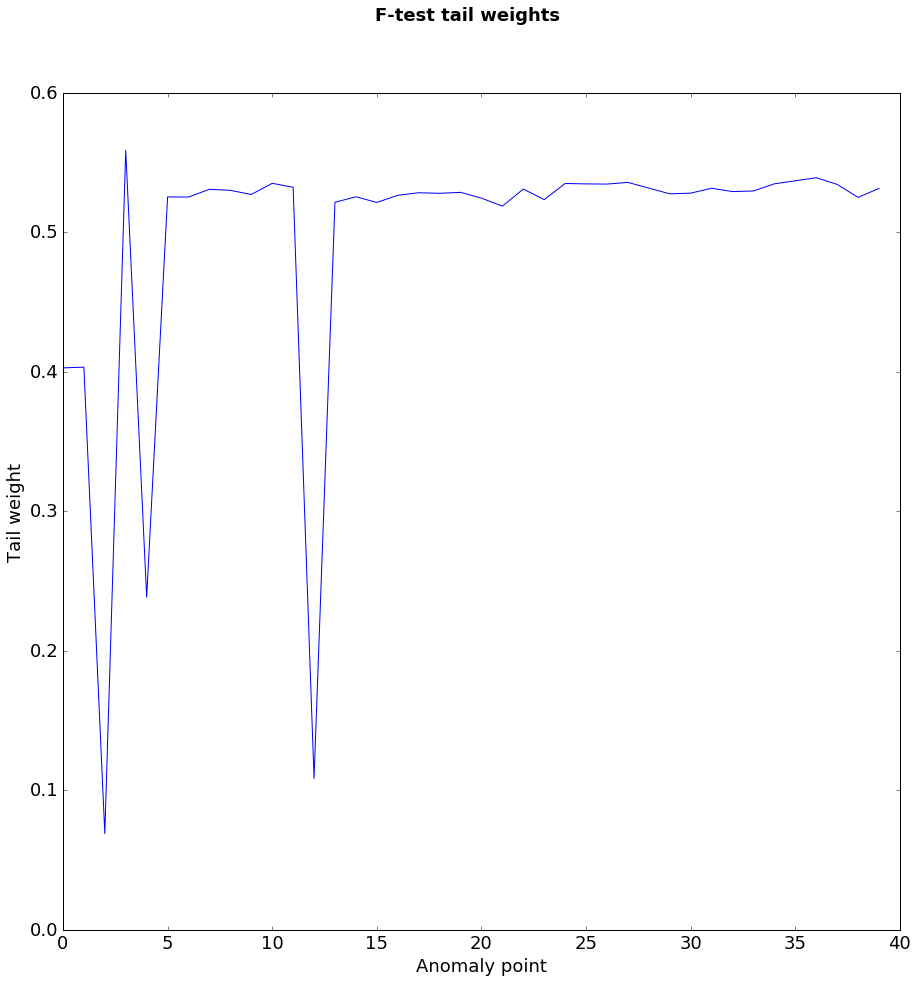

In [12]:
min_f_tail, suspicious_point = display_variances_without_anomalies(t, y, span)

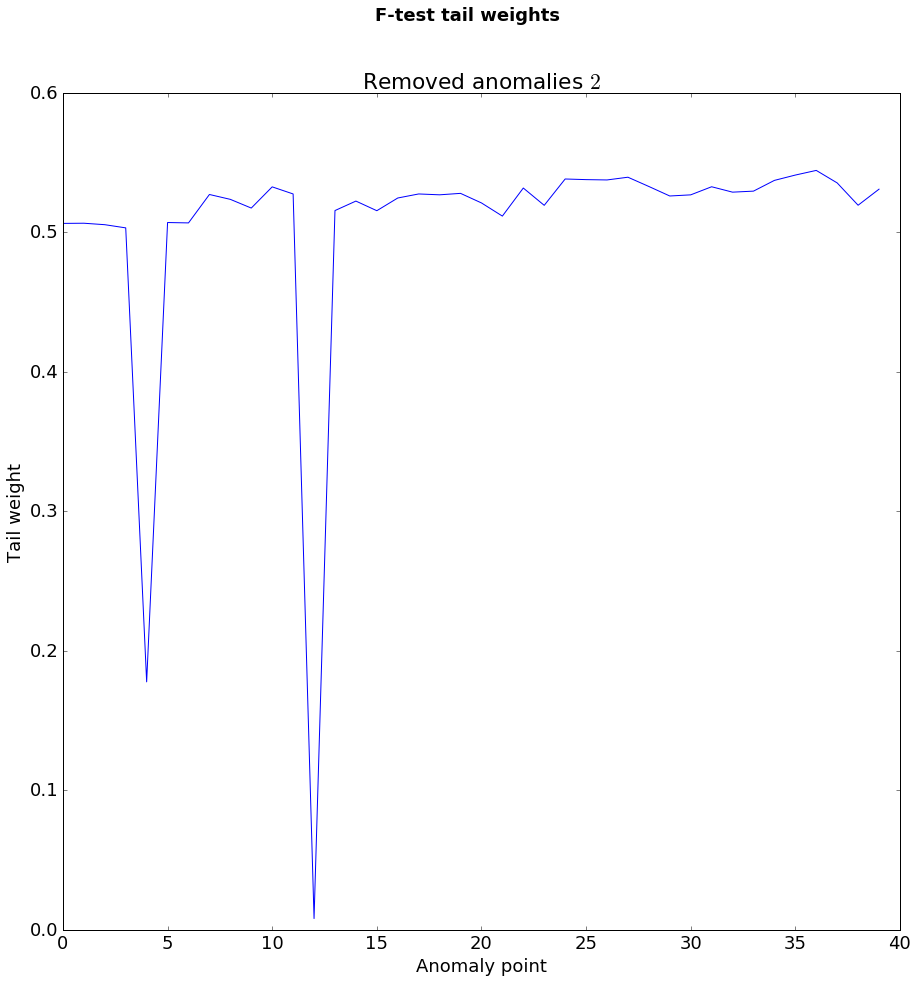

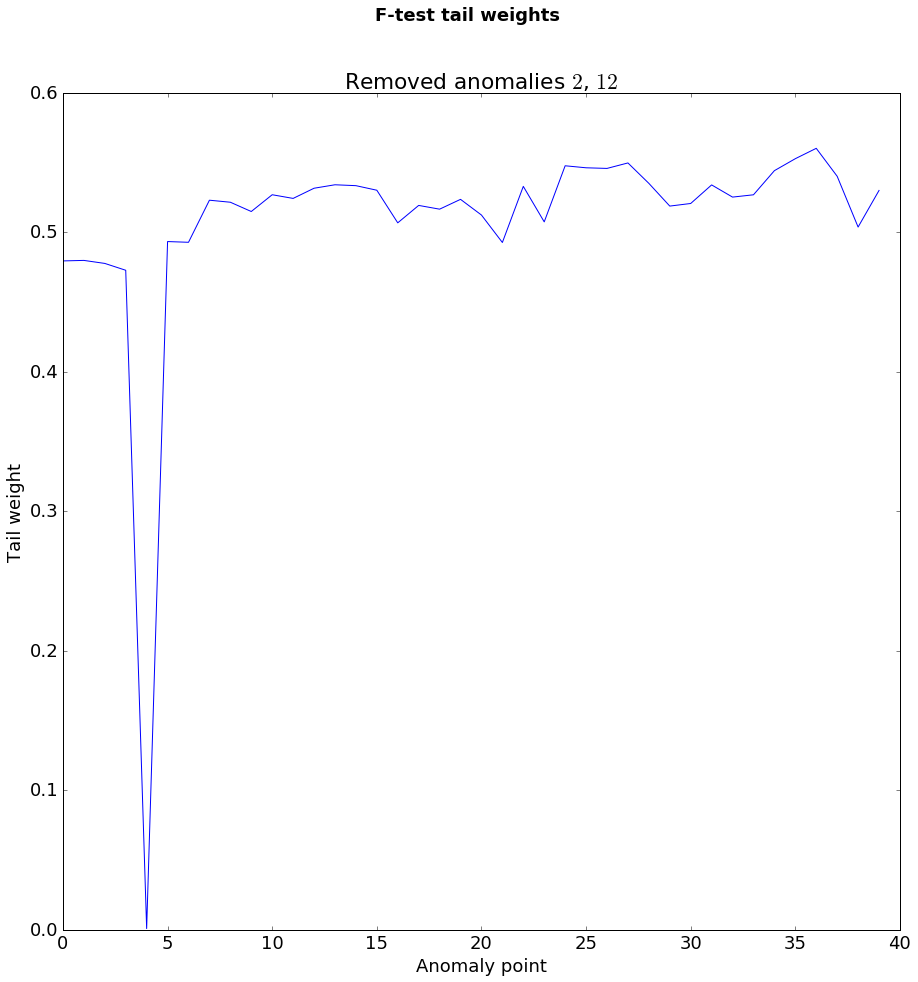

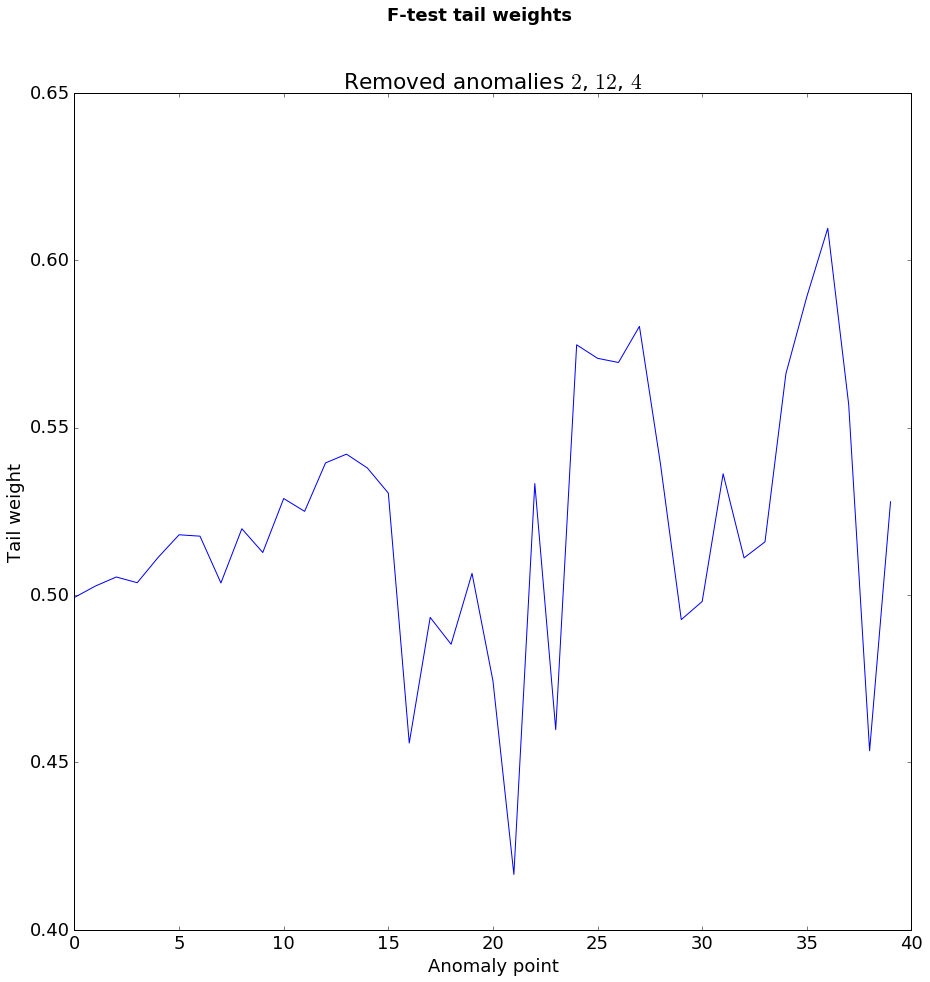

In [13]:
anomaly_points = []
while min_f_tail <= F_TAIL_CRITICAL:
    anomaly_points.append(suspicious_point)
    min_f_tail, suspicious_point = display_variances_without_anomalies(t, y, span, anomaly_points)

In [14]:
y_without_anomalies = y.copy()
# t_without_anomalies = t[:-len(anomaly_points)]
t_without_anomalies = t.copy()
for anomaly_point in anomaly_points:
    y_without_anomalies[anomaly_point] = .5 * (
        y_without_anomalies[anomaly_point - 1] + y_without_anomalies[anomaly_point + 1])

## Without anomalies

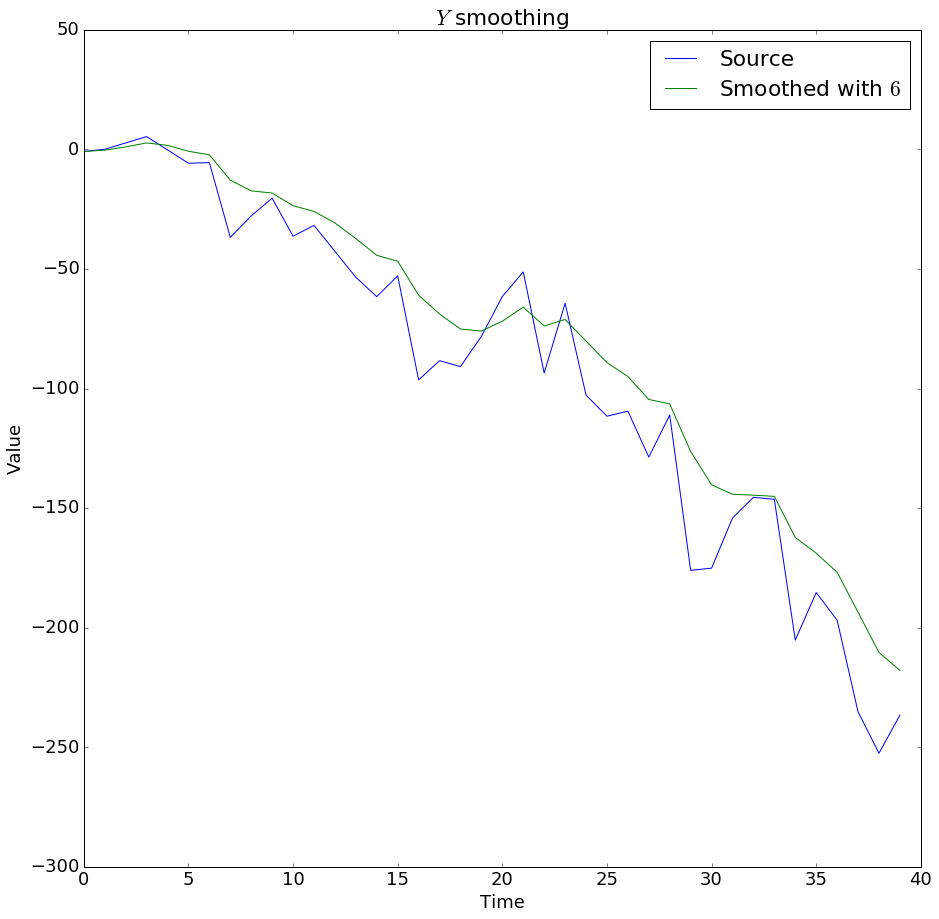

In [15]:
smoothed_y_without_anomalies = data_smoother(y_without_anomalies, span=span)

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies, smoothed_y_without_anomalies, label='Smoothed with $%d$'%span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Choose proper span

We need to find proper span for exponentially-weighted moving average in order to have further calculations right

We know only that distribution of the noise is normal, so we can use
[normality test](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test) of Ralph D'Agostino
and choose the span with which errors have the biggest normality

In [16]:
best_span = get_best_span(y_without_anomalies)

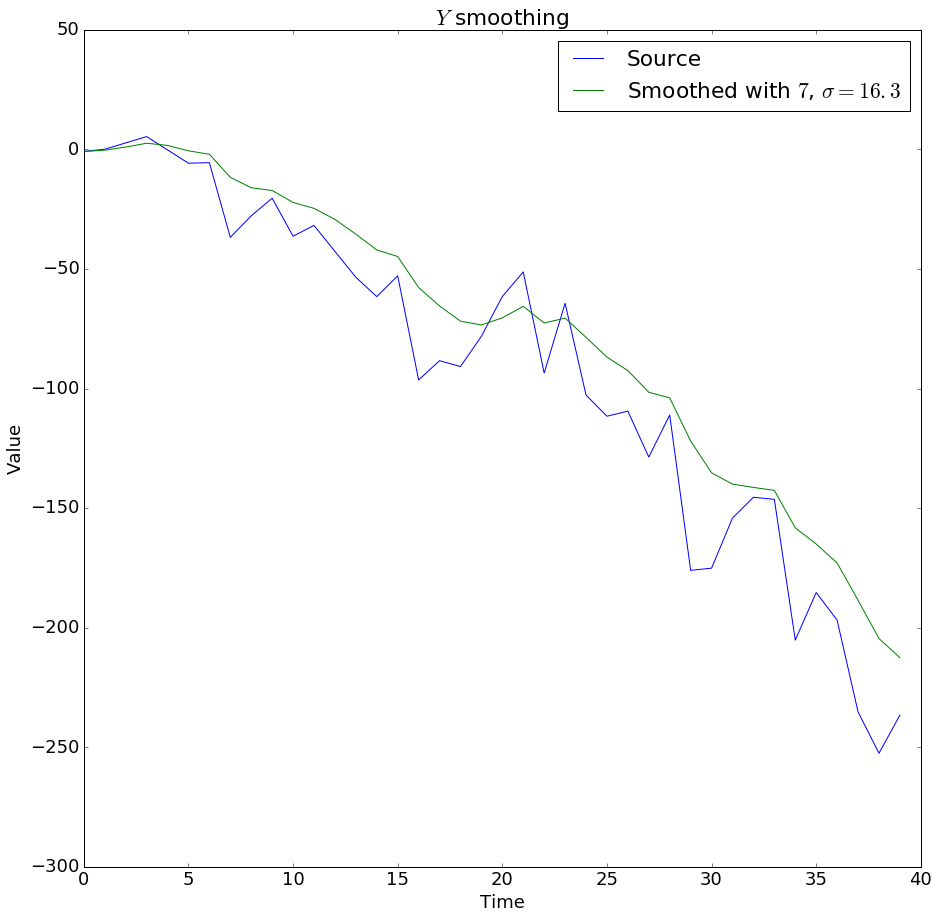

In [17]:
smoothed_y_without_anomalies = data_smoother(y_without_anomalies, span=best_span)
errors = y_without_anomalies - smoothed_y_without_anomalies
trend = smoothed_y_without_anomalies.copy()

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies, smoothed_y_without_anomalies, label=r'Smoothed with $%d$, $\sigma=%2.1f$'%(
        best_span, errors.std()))

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Nonrandom errors

Trend line may cover not all relations between time and value
and a part of relations will occur in errors (difference between trend and data)

Assume we have an estimate $\tilde{Y}$ for data $Y$ and error is defined as
$$
\varepsilon = Y - \tilde{Y}
$$
Our preposition is that there exists $tau$ such as
$$
\varepsilon_{t + \tau} = \delta_{t + \tau} + e_{t + \tau}
$$
where $e$ is a real noise and $\delta$ is a part which depends on previous observations linearly
$$
\delta_{t + \tau} = a_0 + \sum_{i = 0}^{\tau - 1} \delta_{t + i} \cdot a_{i + 1}
$$

Let's take a look at $\varepsilon$

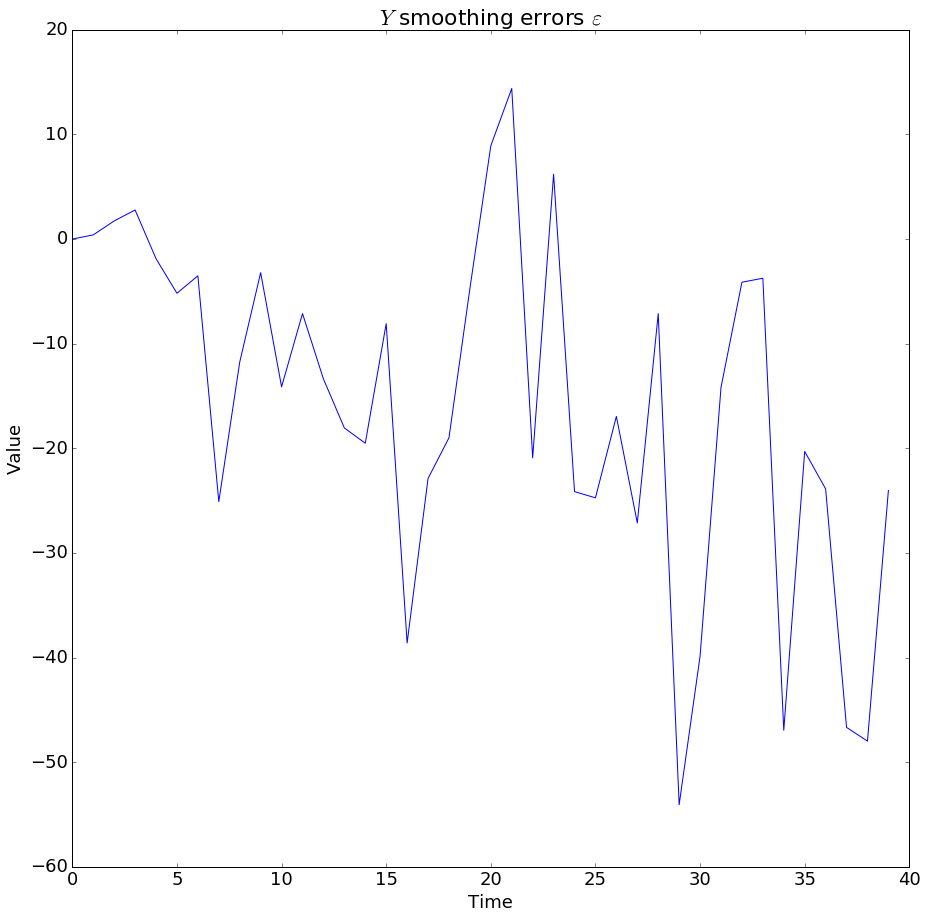

In [18]:
plt.plot(t_without_anomalies, errors)

plt.title(r'$Y$ smoothing errors $\varepsilon$')
plt.ylabel('Value')
plt.xlabel('Time')

plt.show()

To find the $\tau$, which is a lag time, we need to calculate autoregressions for several values of lag

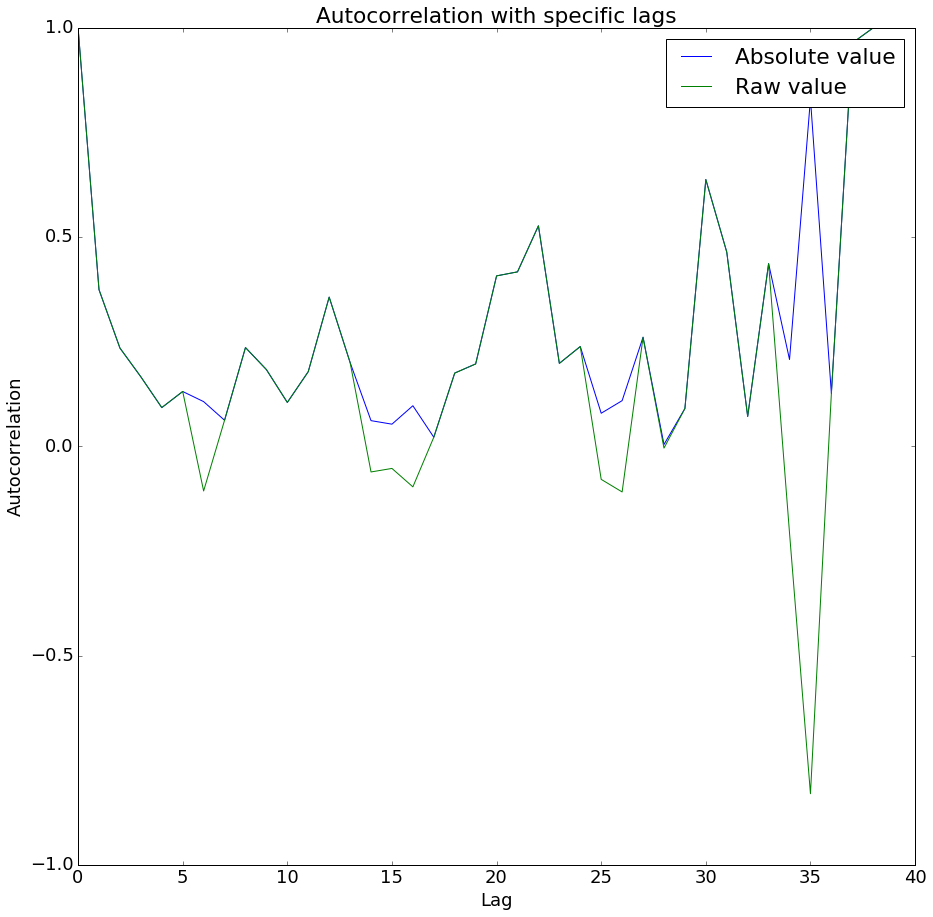

In [19]:
max_lag = errors.size - 1

autocorrelation = array([Series(errors).autocorr(i) for i in range(max_lag)])

plt.plot(list(range(max_lag)), abs(autocorrelation), label='Absolute value')
plt.plot(list(range(max_lag)), autocorrelation, label='Raw value')

plt.title('Autocorrelation with specific lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()

plt.show()

The next step is to choose the lag and calculate coefficients $a_i$ with least square method

In [20]:
lag = 2
result_errors = errors[lag:]
regression_errors = array([concatenate((errors[i - lag:i], [1])) for i in range(lag, errors.size)])
coefficients = lstsq(regression_errors, result_errors)[0]
autoregressors = (coefficients*regression_errors).sum(axis=1)

Now we got a difference between trend and source data, data found by autoregressive analysis and nose

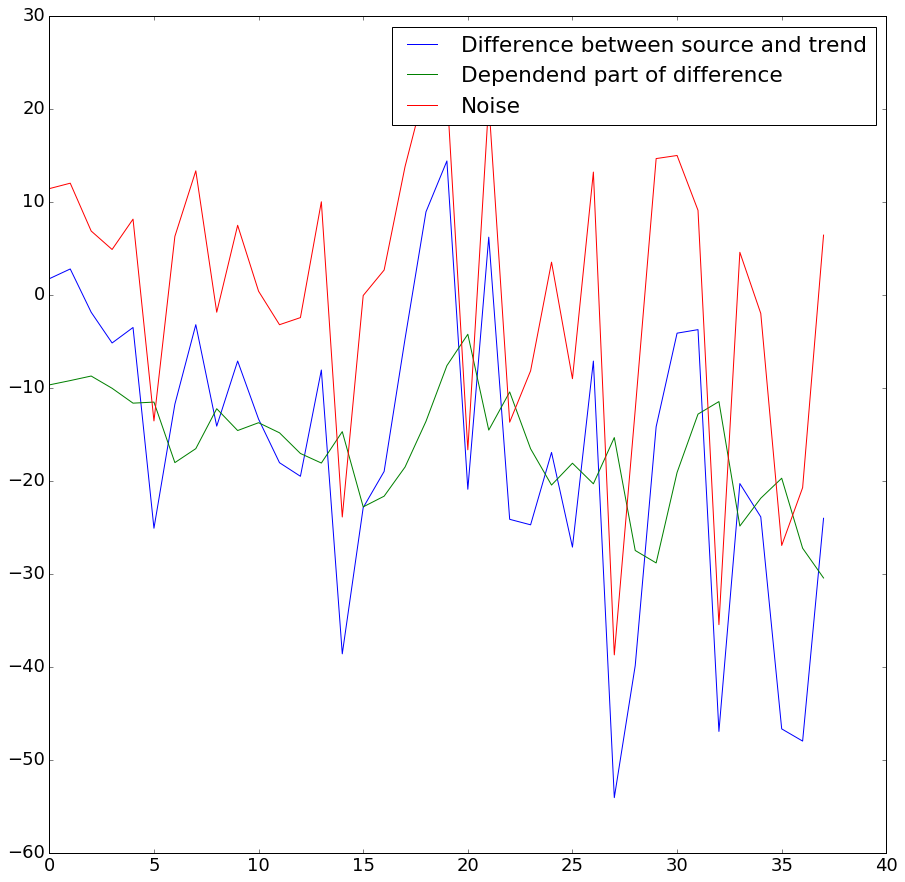

In [21]:
plt.plot(result_errors, label='Difference between source and trend')
plt.plot(autoregressors, label='Dependend part of difference')
plt.plot(result_errors - autoregressors, label='Noise')

plt.legend()
plt.show()

Now we are ready to complete our model with new data

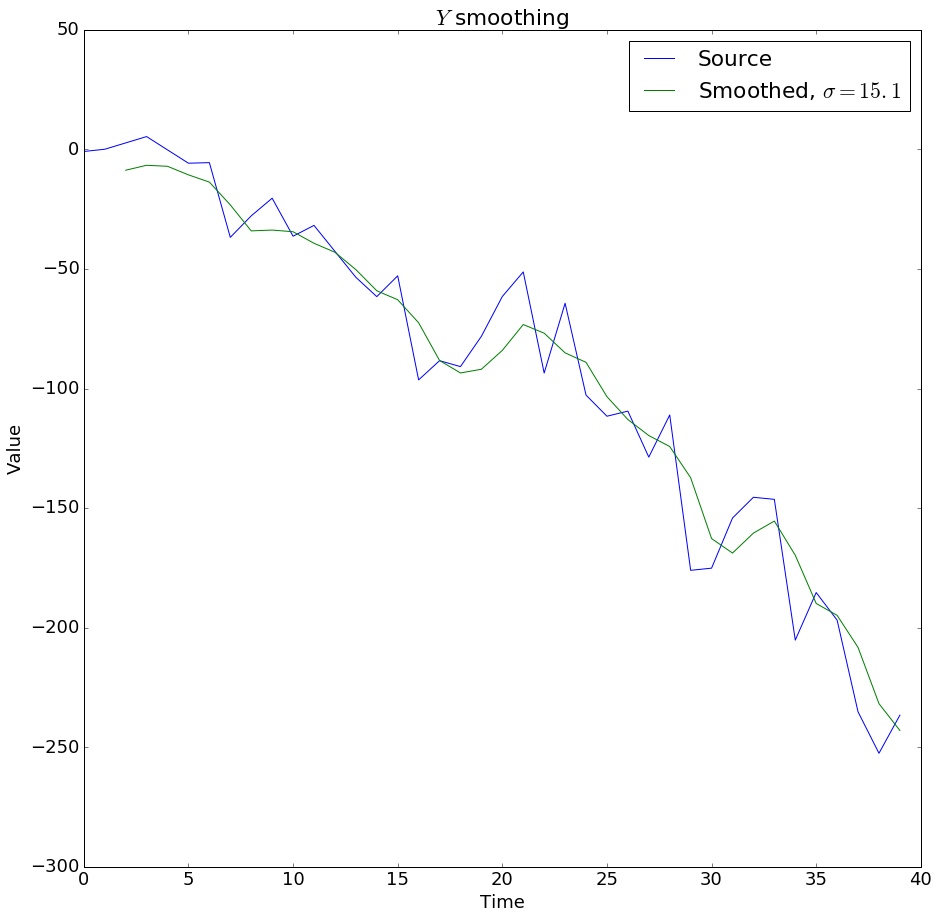

In [22]:
smoothed_y_without_anomalies = data_smoother(y_without_anomalies, span=best_span)[lag:] + autoregressors
errors = y_without_anomalies[lag:] - smoothed_y_without_anomalies

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies[lag:], smoothed_y_without_anomalies, label=r'Smoothed, $\sigma=%2.1f$'%(
        errors.std()))

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

# Forecasting

## Exponentially weighted moving average forecast

Trend line we have can be forecasted for $L$ steps by the formula
$$
Y_{t + L} = \alpha_{0 t} + \alpha_{1 t} \cdot L + \frac{1}{2} \cdot \alpha_{2 t} \cdot L,
$$
where
$$
\begin{cases}
    \alpha_{0 t} = 3 \cdot \left( S_t^1 - S_t^2 \right) + S_t^3, \\
    \alpha_{1 t}
        = \frac{\alpha}{2 \cdot \beta^2} \cdot \left[
            \left( 6 - 5 \cdot \alpha \right) \cdot S_t^1
            - 2 \cdot \left( 5 - 4 \cdot \alpha \right) \cdot S_t^2
            + \left( 4 - 3 \cdot \alpha \right) \cdot S_t^3
          \right], \\
    \alpha_{2 t} = \frac{\alpha^2}{\beta^2} \cdot \left( S_t^1 - 2 \cdot S_t^2 \right) + S_t^3
\end{cases}
$$
and
$$
\begin{cases}
    S_t^1 = \alpha \cdot Y_t + \beta \cdot S_{t-1}^1
          = \alpha \cdot \sum\limits_{i=0}^{t-1} \beta^i \cdot Y_{t-i} + \beta^t \cdot Y_0, \\
    S_t^2 = \alpha \cdot S_t^1 + \beta \cdot S_{t-1}^2, \\
    S_t^3 = \alpha \cdot S_t^2 + \beta \cdot S_{t-1}^3.
\end{cases}
$$

In [23]:
alpha = 2. / (span + 1)

In [24]:
S1 = get_S(trend, alpha)
S2 = get_S(S1, alpha)
S3 = get_S(S2, alpha)

In [25]:
a0 = get_a0(S1, S2, S3, alpha)
a1 = get_a1(S1, S2, S3, alpha)
a2 = get_a2(S1, S2, S3, alpha)

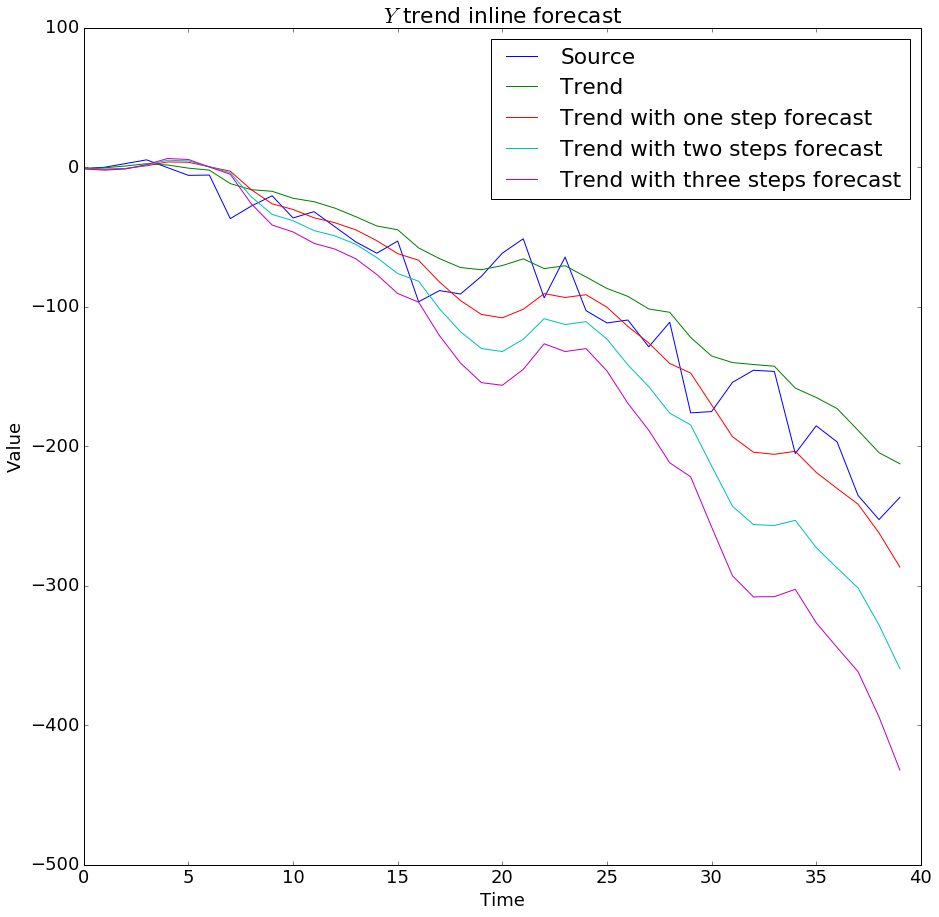

In [26]:
plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies, trend, label='Trend')
plt.plot(t_without_anomalies, [forecast(a0, a1, a2, 1, time) for time in t_without_anomalies], label='Trend with one step forecast')
plt.plot(t_without_anomalies, [forecast(a0, a1, a2, 2, time) for time in t_without_anomalies], label='Trend with two steps forecast')
plt.plot(t_without_anomalies, [forecast(a0, a1, a2, 3, time) for time in t_without_anomalies], label='Trend with three steps forecast')

plt.title('$Y$ trend inline forecast')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

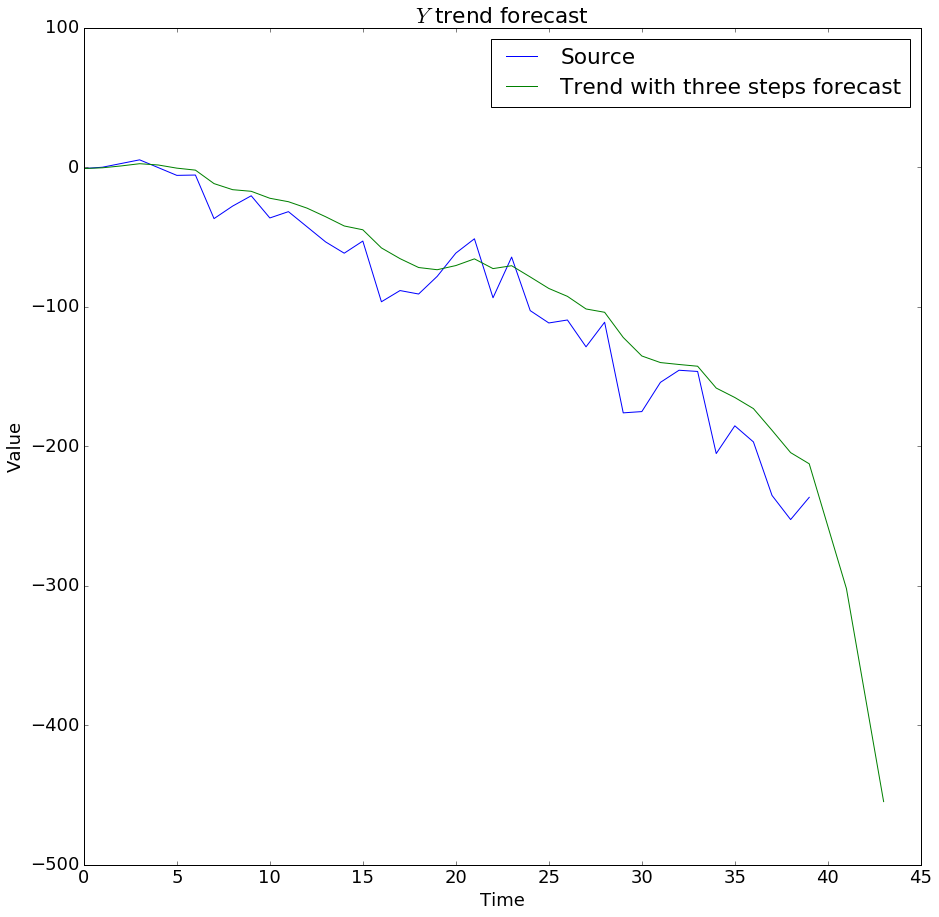

In [27]:
trend_forecasted = concatenate((trend, [forecast(a0, a1, a2, steps) for steps in range(1, 4)]))
plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
time_forecasted = concatenate((t_without_anomalies, list(range(t_without_anomalies.size + 1, t_without_anomalies.size + 4))))
plt.plot(time_forecasted, trend_forecasted, label='Trend with three steps forecast')

plt.title('$Y$ trend forecast')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Autoregression forecast

It's much easier because we have a simple linear formula
$$
\delta_{t + 2} = a_0 + \delta_{t} \cdot a_1 + \delta_{t + 1} \cdot  a_2
$$

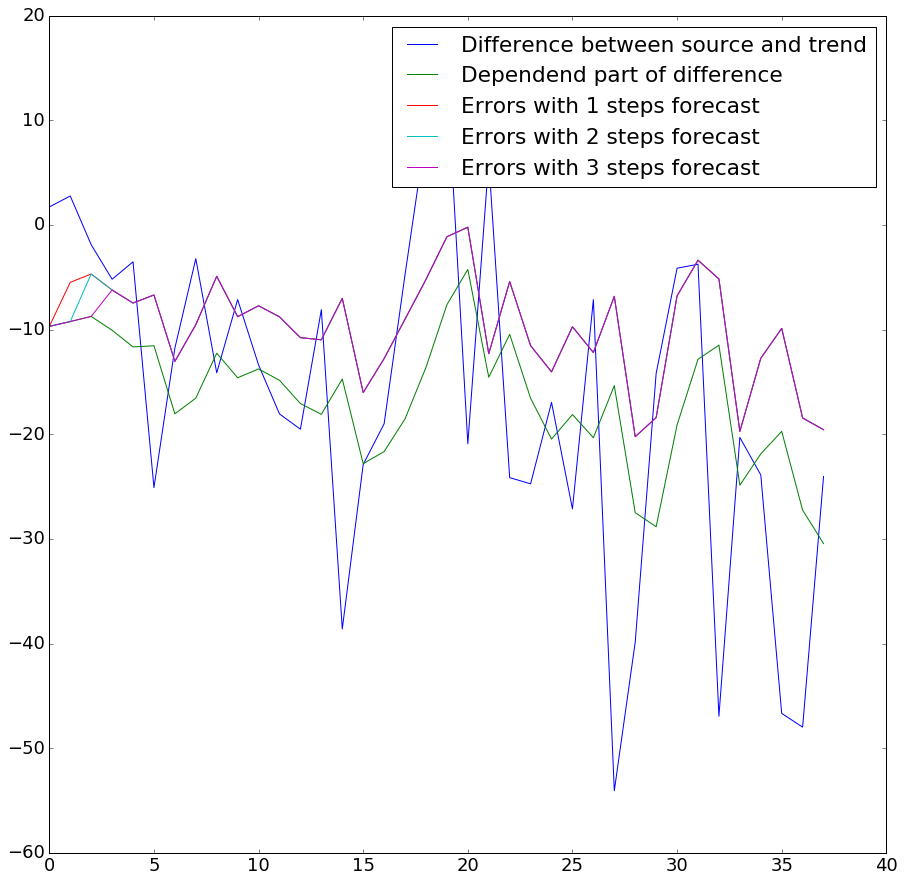

In [28]:
plt.plot(result_errors, label='Difference between source and trend')
plt.plot(autoregressors, label='Dependend part of difference')
for forecast_steps in (1, 2, 3):
    autoregressors_forecast = [get_errors_forecast(errors, coefficients, forecast_steps, time) for time in range(forecast_steps, autoregressors.size)]
    plt.plot(concatenate((autoregressors[:forecast_steps], autoregressors_forecast)), label='Errors with %d steps forecast'%forecast_steps)

plt.legend()
plt.show()

In [29]:
errors_forecasted = autoregressors.copy()
for forecast_steps in (1, 2, 3):
    errors_forecasted = concatenate((errors_forecasted, [get_errors_forecast(errors_forecasted, coefficients)]))

## Resulting forecast

Result contains prediction for trend line and non-random part of errors

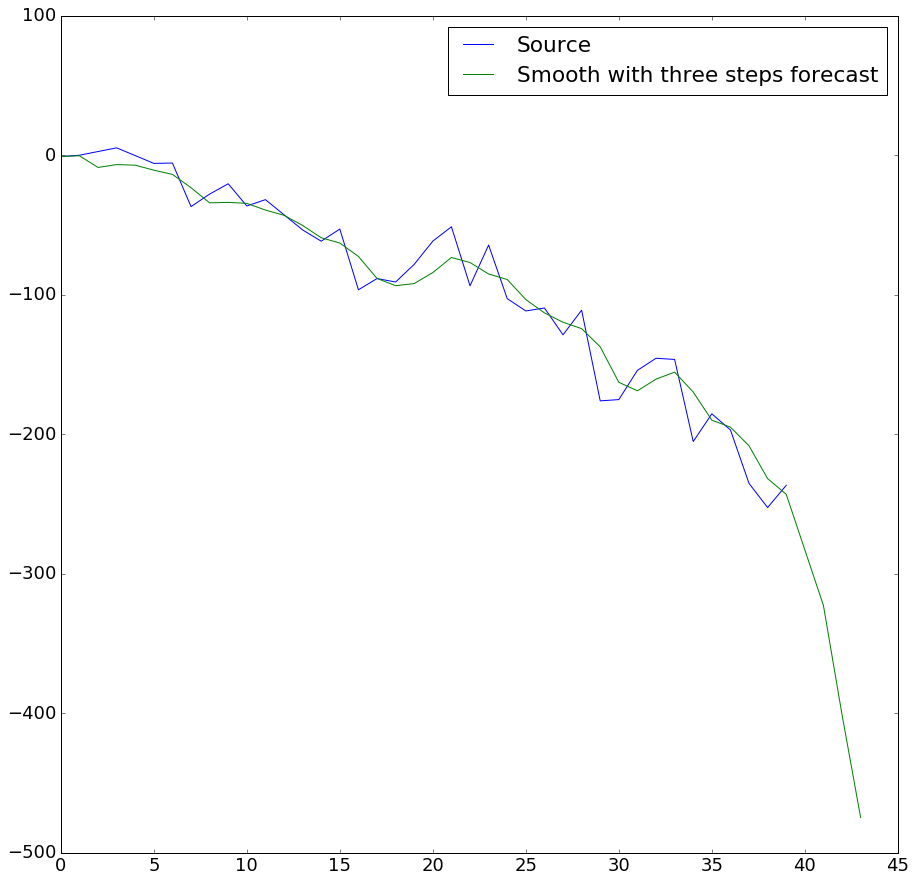

In [30]:
source_series_forecasted = concatenate((trend_forecasted[:2], trend_forecasted[2:] + errors_forecasted))

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(time_forecasted, source_series_forecasted, label='Smooth with three steps forecast')

plt.legend()
plt.show()